### This notebook fits a BERTopic model to the data set and creates topic visualisations.

*Notebook BERTopic_mpnet_2 uses the embeddings where short (3 words or less) tweets were dropped, which might be preferred.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk import TweetTokenizer
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garethsmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Run these two lines to have all plots appear on GitHub (do not run to use interactive plots within this notebook):
import plotly.io as pio

pio.renderers.default = "png"

In [3]:
# Set directory and file paths
READ_DIR = "../data/processed"

FILENAME = "twitter_airline_sentiment_cleaned_emoji_urls_html_symbols@#_quotes_currency_whitespace_flightspellcorrect"

EMBEDDING_MPNET = "twitter_airline_sentiment_cleaned_emoji_urls_html_symbols@#_quotes_currency_whitespace_flightspellcorrect_all-mpnet-base-v2.npy"

In [4]:
# Load embeddings
embeddings_mpnet = np.load(f"{READ_DIR}/{EMBEDDING_MPNET}")

In [5]:
# Load text data
df = pd.read_csv(f"{READ_DIR}/{FILENAME}.csv")

#### Set customisable parameters for BERTopic components:

In [6]:
# Parameters for UMAP
n_neighbors = 15
n_components = 5
min_dist = 0.1
metric_umap = "cosine"
random_state = 0

# UMAP model
reducer = UMAP(
    n_neighbors=n_neighbors,
    n_components=n_components,
    min_dist=min_dist,
    metric=metric_umap,
    random_state=random_state,
)

# Parameters for HDBScan
min_cluster_size = 15
min_samples = 5
metric_hdbscan = "euclidean"
cluster_selection_method = "eom"

# HDBScan model
clusterer = HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric=metric_hdbscan,
    cluster_selection_method=cluster_selection_method,
    prediction_data=True,
)

# The lower and upper boundary of the range of n-values for different word n-grams
# or char n-grams to be extracted:
ngram_range = (1, 2)

#### Create functions to fit BERTopic model:

In [7]:
def get_bertmodel(ngram_range, umap_model, hdbscan_model):
    # Convert a collection of text documents to a matrix of token counts:
    vectorizer = CountVectorizer(
        stop_words=stopwords.words("english"),
        tokenizer=TweetTokenizer().tokenize,
        token_pattern=None,
        ngram_range=ngram_range,
    )

    # Fit BERTopic model with customisation:
    topic_model = BERTopic(
        vectorizer_model=vectorizer,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
    )

    return topic_model


def get_topics_probs(model, docs, embeddings):
    topics, probs = model.fit_transform(docs, embeddings=embeddings)
    return topics, probs


def fit_bert(docs, embeddings, ngram_range, umap_model, hdbscan_model):
    bertmodel = get_bertmodel(
        ngram_range=ngram_range, umap_model=umap_model, hdbscan_model=hdbscan_model
    )

    topics, probs = get_topics_probs(model=bertmodel, docs=docs, embeddings=embeddings)

    return bertmodel, topics, probs

#### Fit BERTopic model using MPNET embeddings:

In [8]:
bertmodel_mpnet, topics_mpnet, probs_mpnet = fit_bert(
    docs=list(df.clean_text),
    embeddings=embeddings_mpnet,
    ngram_range=ngram_range,
    umap_model=reducer,
    hdbscan_model=clusterer,
)

##### Display the results table:
note: Topic -1 represents outliers 

In [9]:
df_bertopics_mpnet = bertmodel_mpnet.get_topic_info()
print("Number of topics: {}".format(len(df_bertopics_mpnet)))
df_bertopics_mpnet["Percentage"] = round(
    df_bertopics_mpnet["Count"] / df_bertopics_mpnet["Count"].sum() * 100, 2
)
df_bertopics_mpnet[:30]

Number of topics: 126


,Topic,Count,Name,Representation,Representative_Docs,Percentage
0,-1,7182,-1_flight_get_cancelled_plane,"[flight, get, cancelled, plane, us, time, serv...",[4 flights cancelled in one week?! Customer Se...,49.78
1,0,1041,0_bag_luggage_bags_baggage,"[bag, luggage, bags, baggage, lost, claim, lef...",[terrible illogical re-route after cancelled c...,7.22
2,1,416,1_great_thanks_crew_thank,"[great, thanks, crew, thank, great flight, att...","[Another great flight & crew, Las Vegas-Chicag...",2.88
3,2,414,2_hold_call_phone_minutes,"[hold, call, phone, minutes, hours, call back,...","[2 hours on hold. Still no answer. Horrible., ...",2.87
4,3,166,3_hold_cancelled_cancelled flight_rebook,"[hold, cancelled, cancelled flight, rebook, fl...",[been on hold for almost 2 hours trying to reb...,1.15
5,4,131,4_seat_seats_sit_window,"[seat, seats, sit, window, seating, row, avail...",[requested window seat and confirmed window bu...,0.91
6,5,121,5_united_united airlines_fly united_united flight,"[united, united airlines, fly united, united f...",[Priceless. United stranded my daughter at O'H...,0.84
7,6,120,6_airline_worst airline_worst_airline ever,"[airline, worst airline, worst, airline ever, ...","[is the worst airline to ever travel with., is...",0.83
8,7,118,7_hotel_cancelled_cancelled flight_flight,"[hotel, cancelled, cancelled flight, flight, f...",[. You neglected to mention the $200 fee per t...,0.82
9,8,112,8_tweet_twitter_tweeting_media,"[tweet, twitter, tweeting, media, tweets, soci...","[Are you out of your mind, AA? What is the poi...",0.78


#### Choose a topic number and print data from the corresponding row:

In [10]:
topic_num = 0
for i, v in df_bertopics_mpnet.iloc[topic_num + 1].items():
    print(f"{i} : {v}")

Topic : 0
Count : 1041
Name : 0_bag_luggage_bags_baggage
Representation : ['bag', 'luggage', 'bags', 'baggage', 'lost', 'claim', 'left', 'checked', 'carry', 'baggage claim']
Representative_Docs : ['terrible illogical re-route after cancelled connection. Then made me pay to check bag. Then lost bag.', 'Very frustrated, checked bag in Logan, was not given a luggage ticket, now luggage is lost & no ownership from', 'lost our luggage.']
Percentage : 7.22


#### Show topic words and c-TF-IDF scores:

In [11]:
bertmodel_mpnet.get_topic(0)

[('bag', 0.030621938246794152),
 ('luggage', 0.02132110680817663),
 ('bags', 0.021003947959779997),
 ('baggage', 0.017840891312885014),
 ('lost', 0.014028019398263186),
 ('claim', 0.00878909003270865),
 ('left', 0.007479401883626106),
 ('checked', 0.00697868922987062),
 ('carry', 0.006462517239209944),
 ('baggage claim', 0.006320216057100575)]

##### For each topic, we can observe the most important words, sorted in decreasing order based on the c-TF-IDF score:

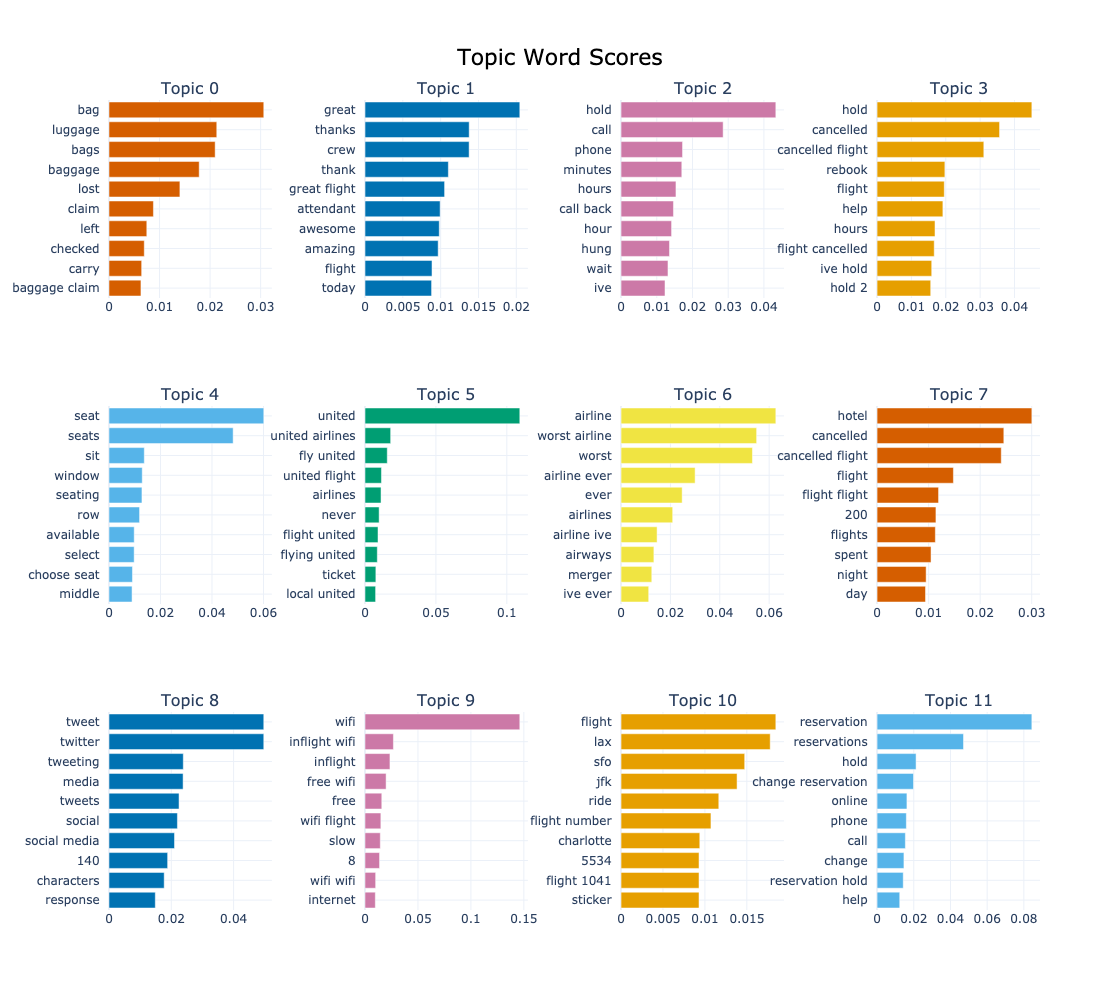

In [12]:
barchart = bertmodel_mpnet.visualize_barchart(
    width=280, height=330, top_n_topics=12, n_words=10
)
barchart.show()

### Looking at sample of outliers:

In [14]:
df_topics = pd.DataFrame(
    {"Document": df["clean_text"], "Topic": bertmodel_mpnet.topics_}
)

outlier_tweets = df_topics["Document"][df_topics["Topic"] == -1]

[print(tweet) for tweet in outlier_tweets.sample(15, random_state=11)]

better do the right thing and take care of or els you're losing business!!!!
I still can't get through to change my flight. This is really important plz help!
my SIL bought tix for us to NYC. We were told at the gate that her cc was declined. Supervisor accused us of illegal activity.
my son is flying South West from NOLA-Orlando, hope to enter for him to win this contest
Hi! Know a pastor or homeschool mom who might like SpiritED? Have 'em contact me on Prefundia:http://t. co/jRbZLHRW7y
We've been on hold for over 7 hours after my wife's flight was cancelled.
No. Had to Cancelled Flight my trip. Instead of a $25 future trip voucher, a $25 drink coupon would've been better!
each flight is worse than last! flight attendants don't even know whether the plane is equipped with power outlets at the seats!
I flew US Air for the first time yesterday, got propositioned by the flight attendant... .true story!
Thanks, Lindsey. Any idea when I'll get there?! Stuck in Denver and told to "listen to

### What about merging topics? For example, where are the topics about delays? 

In [15]:
df_topics["Topic"][df_topics["Document"].str.contains("delay")].value_counts()[:10]

Topic
-1     525
 14     57
 32     50
 0      43
 33     23
 78     18
 1      17
 18     12
 38      9
 23      9
Name: count, dtype: int64

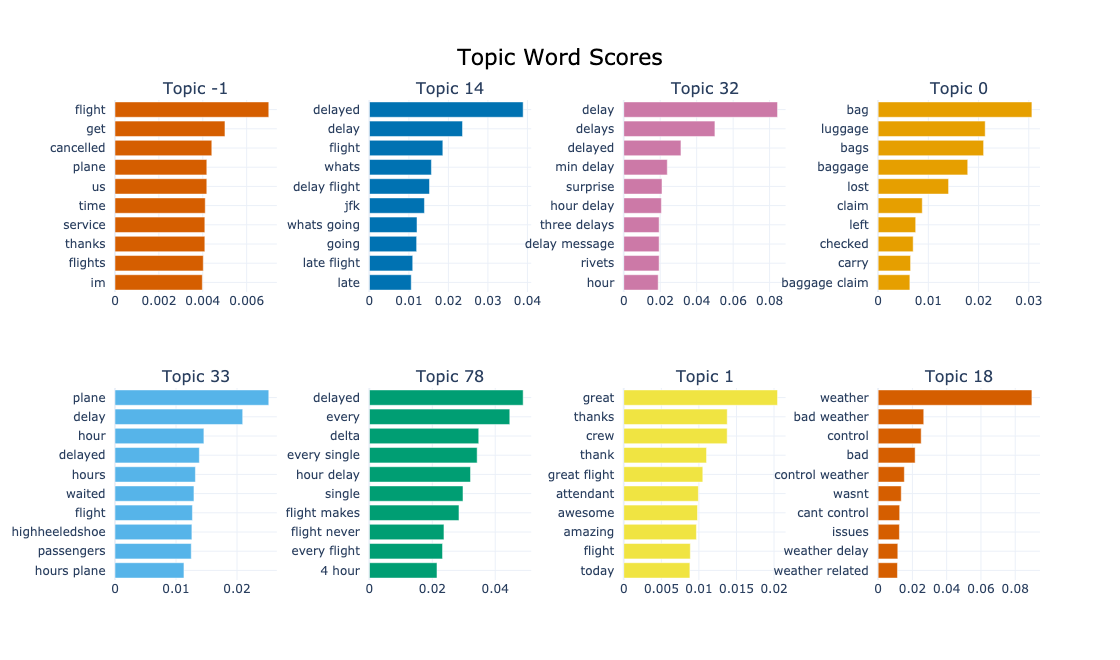

In [16]:
barchart = bertmodel_mpnet.visualize_barchart(
    width=280, height=330, topics=[-1, 14, 32, 0, 33, 78, 1, 18], n_words=10
)
barchart.show()

In [17]:
# Look at samples of the topics that appear to be most specifically about delays:
for topic in [14, 32, 33, 78]:
    [print(t) for t in bertmodel_mpnet.get_representative_docs(topic)]
    print()

being told JFK had a 5 hour delay this AM which is reason for my delay now. It can't be that hard to notify with 12 hours notice
is my flight delayed? It keeps changing between delayed and not??? If delayed is checkin time later???
Delayed: AA3186 - Missed due to delay: AA3186 - New flight now delayed: AA2401

it's not about the delay. It's about the communication.
while listening to a delay message on my phone, another delay message was coming in. Get your shit together!
30 min delay for mechanics to replace rivets. 30 mins later, turns out mechanics had wrong size rivets. 35 more mins. Pathetic

, last week shanghai to sfo 858 delay 5hrs bc of engine. today sfo-sea delay to "sick pilot". no compensation. They Do. Not. Care.
been sitting on the tarmac for 90 mins now bc engine is broken. How are u going to compensate passengers
flight 623 den to phx: flight attdt decides to stay downtown and be an hour Late Flight so entire flight delayed, she better get fired!

seriously? Every fligh

In [18]:
# Look at more samples from topic 33
list(df_topics["Document"][df_topics["Topic"] == 33][:10])

['should I be concerned that I am about to fly on a plane that needs to be delayed due to a "tech stop"?',
 "flight was scheduled for 11:56, it's 1:05 and we haven't moved. I have never been on a flight where everyone moved without a sense",
 ', last week shanghai to sfo 858 delay 5hrs bc of engine. today sfo-sea delay to "sick pilot". no compensation. They Do. Not. Care.',
 "doesn't help the 100 or more passengers that just arrived an hour Late Flight.",
 'except all of that delayed the flight anyway.',
 'Never had a flight delayed an hour due to an unbalanced load. And more delays at. Great job idiots.',
 'Delayed 7 hrs flight 5721 PIT/IAD, finally board the plane, sit half hour & crew is at their hrs limit & we deplane. Unacceptable.',
 'leadership counts. landed at 11:15 last night-deplaned at 12:40. 45 minutes of that was waiting for the jetway. Inexcusable',
 'the incompetence is truly stunning at this point. 4 hours on a plane for a 1.75 hour nonstop flight.',
 'we are sitting o

#### The above look to be mostly delay-oriented, so now to merge:

### Merging topics about delays:

In [19]:
topics_to_merge = [14, 32, 33, 78]
bertmodel_mpnet.merge_topics(df["clean_text"], topics_to_merge)

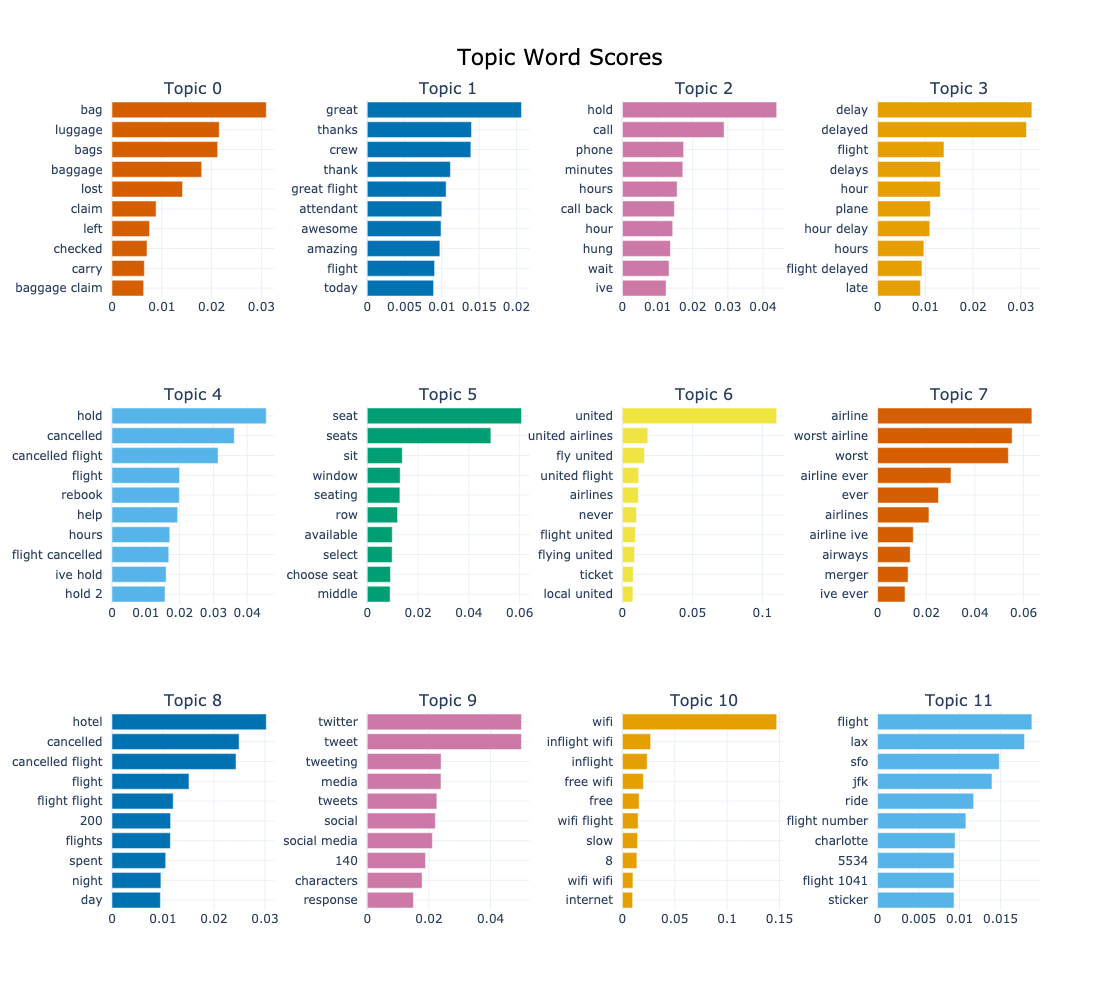

In [20]:
barchart = bertmodel_mpnet.visualize_barchart(
    width=280, height=330, top_n_topics=12, n_words=10
)
barchart.show()

#### We can also see the distribution of topics per class, i.e. per Airline in this case:

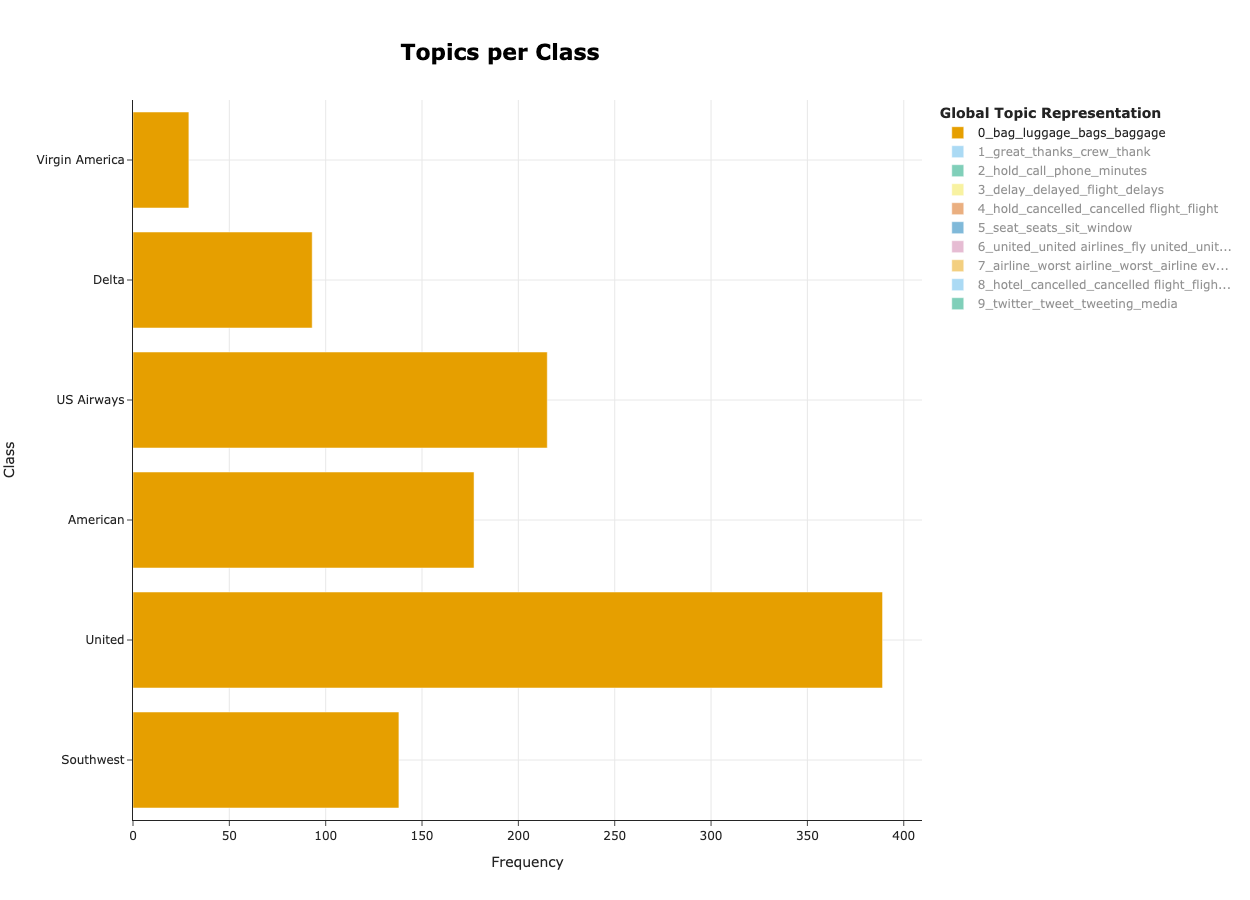

In [21]:
topics_per_class = bertmodel_mpnet.topics_per_class(
    df["clean_text"], classes=df["airline"]
)

bertmodel_mpnet.visualize_topics_per_class(
    topics_per_class, top_n_topics=10, normalize_frequency=False
)

## Look at document info table:

In [22]:
df_doc = bertmodel_mpnet.get_document_info(df["clean_text"])
df_doc["Airline"] = df["airline"]
df_doc.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,Airline
0,What said.,-1,-1_flight_get_cancelled_us,"[flight, get, cancelled, us, plane, time, than...",[4 flights cancelled in one week?! Customer Se...,flight - get - cancelled - us - plane - time -...,0.0,False,Virgin America
1,plus you've added commercials to the experienc...,-1,-1_flight_get_cancelled_us,"[flight, get, cancelled, us, plane, time, than...",[4 flights cancelled in one week?! Customer Se...,flight - get - cancelled - us - plane - time -...,0.0,False,Virgin America
2,I didn't today... Must mean I need to take ano...,33,33_yes_baggage_nope_loading,"[yes, baggage, nope, loading, would get, ticke...","[nope, they told us it was time for them to go...",yes - baggage - nope - loading - would get - t...,1.0,False,Virgin America
3,"it's really aggressive to blast obnoxious ""ent...",-1,-1_flight_get_cancelled_us,"[flight, get, cancelled, us, plane, time, than...",[4 flights cancelled in one week?! Customer Se...,flight - get - cancelled - us - plane - time -...,0.0,False,Virgin America
4,and it's a really big bad thing about it,-1,-1_flight_get_cancelled_us,"[flight, get, cancelled, us, plane, time, than...",[4 flights cancelled in one week?! Customer Se...,flight - get - cancelled - us - plane - time -...,0.0,False,Virgin America


#### It would be useful to plot topic counts normalised by total tweets per airline, so we can see the prevalence of particular themes,<br> e.g. complaints as a fraction of total tweets. <br>
#### The dataset was scraped in a single month (February 2015), but how the data were scraped is not described in the source. Therefore, it is unclear how much of the total content on Twitter related to these operators is present. <br>
#### For the purpose of this investigation I will treat it as complete, but for real-world applications you would want to scrape all data related to a given set of operators over a long (possibly continuous) time period.

In [23]:
# Create a dictionary to map airline to total number of tweets associated
docs_per_airline = df["airline"].value_counts().to_dict()
docs_per_airline

{'United': 3805,
 'US Airways': 2906,
 'American': 2594,
 'Southwest': 2408,
 'Delta': 2211,
 'Virgin America': 503}

In [24]:
def plot_normalised_topics(
    data: pd.DataFrame,
    topics2plot: list[str],
    groupby_cols: list[str] = ["Topic", "Airline", "Name"],
    count_apply_col: str = "Airline",
    label_col: str = "Name",
    norm_dict: dict = docs_per_airline,
):
    """Function to plot normalised topic counts by a certain feature, e.g. count_apply_col = Airline"""
    df2plot = (
        data.groupby(groupby_cols)[count_apply_col].count().reset_index(name="Count")
    )
    df2plot_ = df2plot[df2plot["Topic"].isin(topics2plot)]
    df2plot_["Percentage"] = 100 * df2plot_.apply(
        lambda x: x["Count"] / norm_dict[x[count_apply_col]], axis=1
    )
    sns.barplot(df2plot_, x=count_apply_col, y="Percentage", hue=label_col).set_title(
        "Normalised topics"
    )
    plt.gcf().set_size_inches(12, 8)

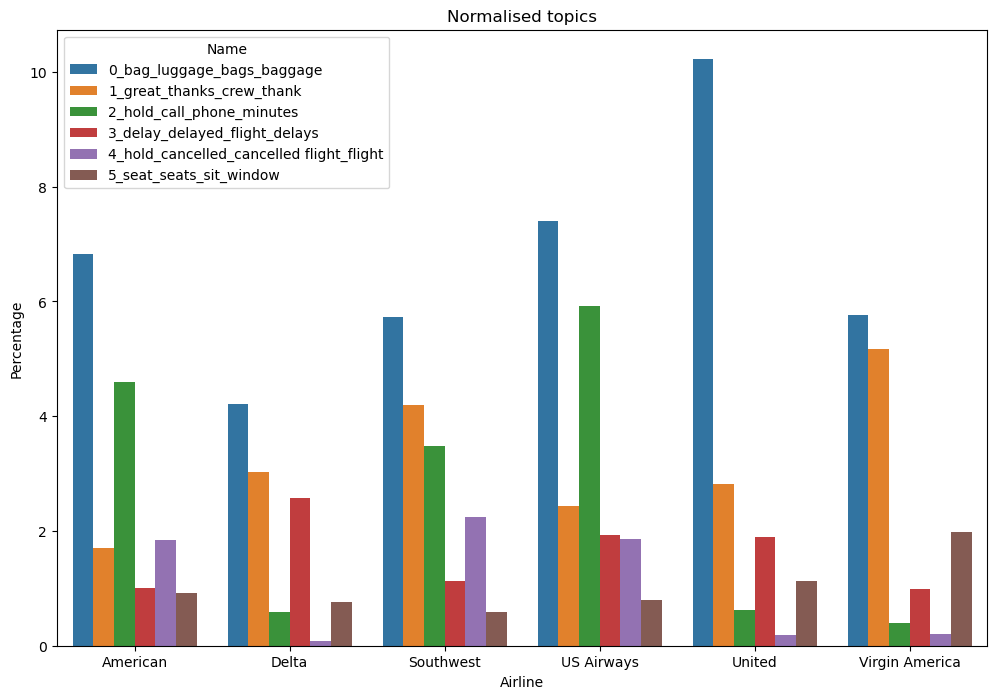

In [25]:
plot_normalised_topics(
    data=df_doc,
    topics2plot=[0, 1, 2, 3, 4, 5],
    groupby_cols=["Topic", "Airline", "Name"],
    count_apply_col="Airline",
    label_col="Name",
    norm_dict=docs_per_airline,
)

From the above, it appears that:
- United have the biggest issues related to baggage, although it's prevalent for all airlines
- Virgin have the greatest proportion of comments relating to thanking them
- American, Southwest and US Airways have siginificant issues related to being on hold on the phone
- Delta are most affected by delays
- Delta, United and Virgin America have the few problems with being on hold relating to cancelled flights
- Virgin has significant comment (likely complaints) related to seats

In [26]:
# Print samples of the topics from above:
for topic in [0, 1, 2, 3, 4, 5]:
    [
        print(f"Topic {topic}: {t}")
        for t in bertmodel_mpnet.get_representative_docs(topic)
    ]
    print()

Topic 0: terrible illogical re-route after cancelled connection. Then made me pay to check bag. Then lost bag.
Topic 0: Very frustrated, checked bag in Logan, was not given a luggage ticket, now luggage is lost & no ownership from
Topic 0: lost our luggage.

Topic 1: Another great flight & crew, Las Vegas-Chicago. Thanks!
Topic 1: Great flight, as always! Thank you to the great crew on flight 475!
Topic 1: great flight

Topic 2: 2 hours on hold. Still no answer. Horrible.
Topic 2: been on hold for 1.5 hrs. What's up?
Topic 2: been on hold for over and hour now.

Topic 3: you know it's bad when you're praying your connecting flight is delayed because of an hour delay on the first flight
Topic 3: delayed to10.30!!
Topic 3: Never can get a flight out on time. 4 hour delay earlier another hour delay on my connecting flight. Makes 10 straight delays

Topic 4: been on hold for almost 2 hours trying to rebook my cancelled flight. What in the world?!!!
Topic 4: we've been on hold for 2 hours t

#### Create a 2D representation of the topics:

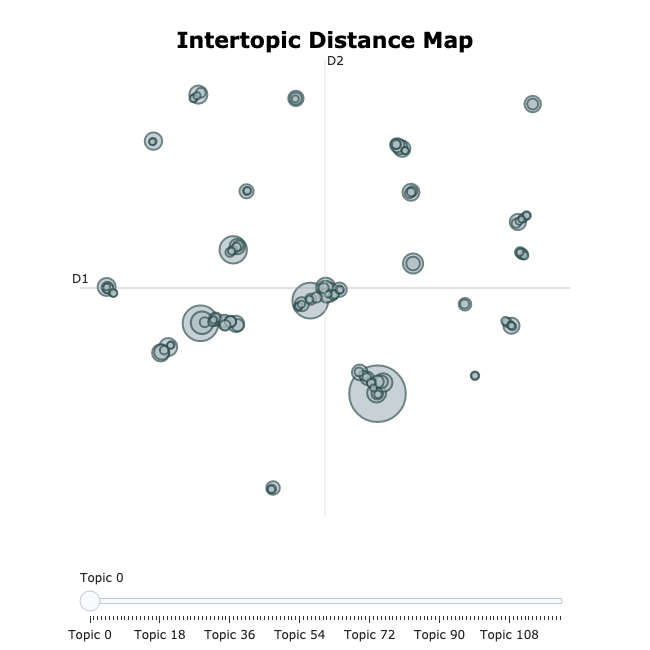

In [27]:
distance_map = bertmodel_mpnet.visualize_topics()
distance_map.show()

#### Visualise topic similarity with a heatmap:

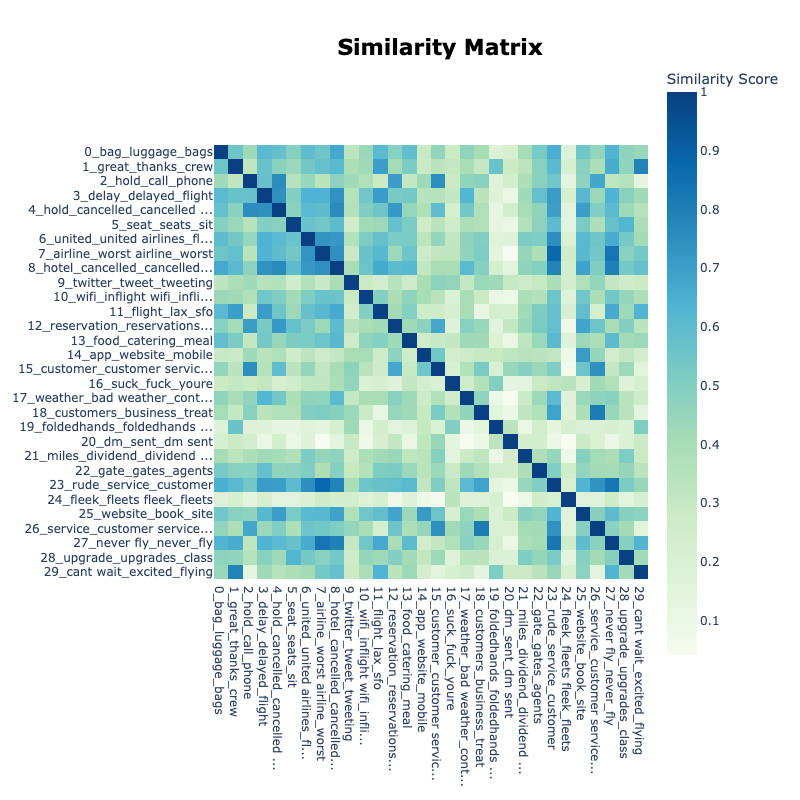

In [28]:
similarity_matrix = bertmodel_mpnet.visualize_heatmap(top_n_topics=30)
similarity_matrix.show()

#### We can also specify a number of clusters before creating the similarity matrix. Similar themes are then grouped together:

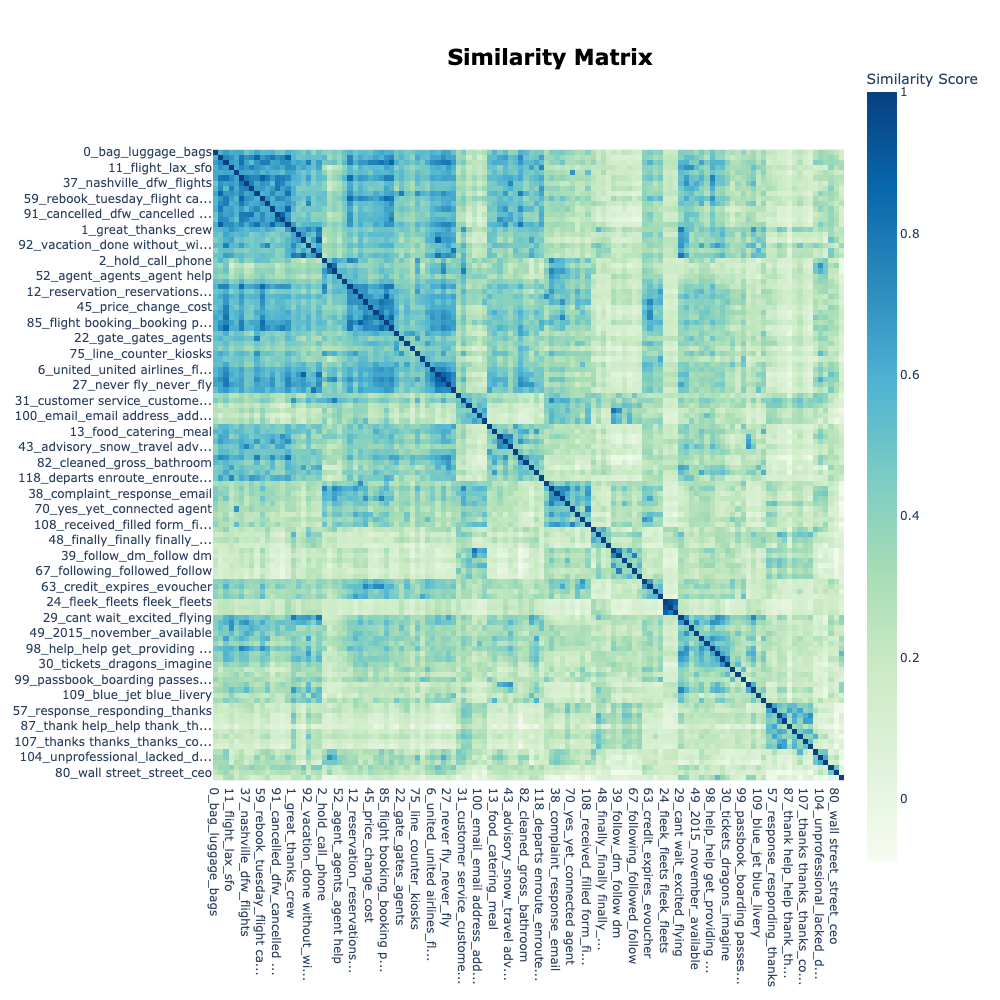

In [29]:
similarity_matrix = bertmodel_mpnet.visualize_heatmap(
    height=1000, width=1000, n_clusters=20
)
similarity_matrix.show()

#### Now visualise the documents within topics:

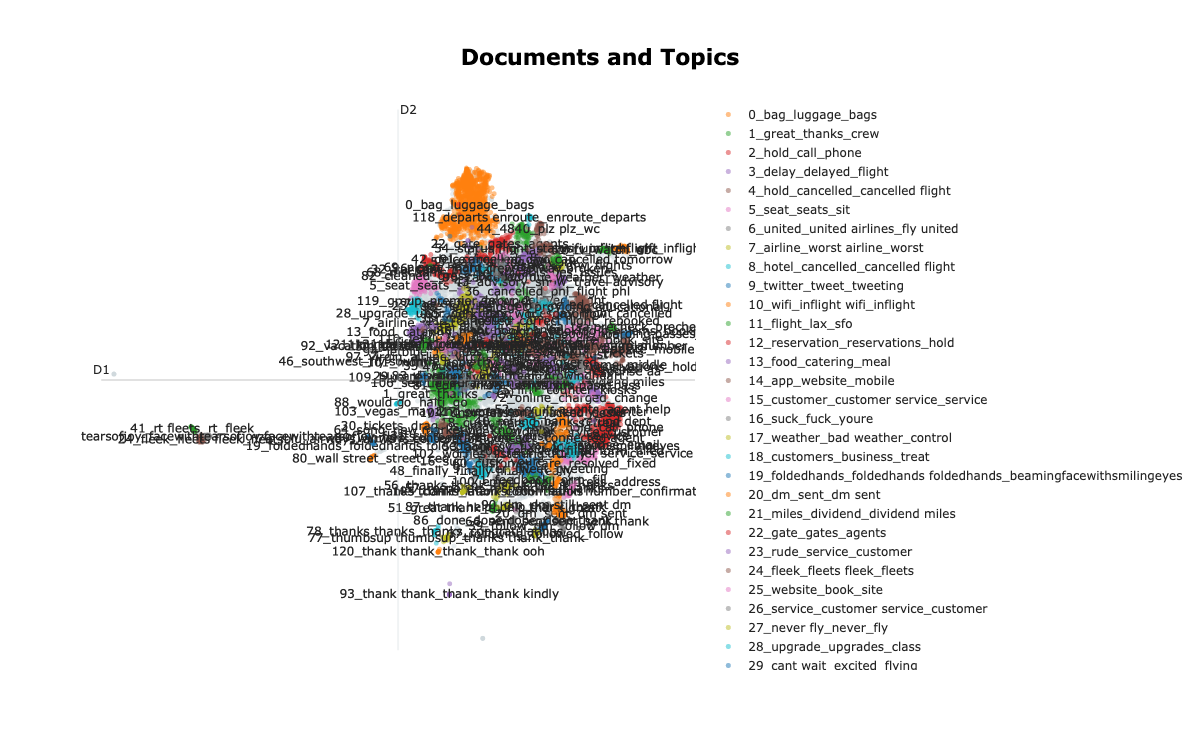

In [30]:
# Run the visualization with the original embeddings
# And viewing the original tweet text
bertmodel_mpnet.visualize_documents(docs=list(df.text), embeddings=embeddings_mpnet)

umap_vis = UMAP(
    n_neighbors=n_neighbors,
    n_components=2,
    min_dist=min_dist,
    metric=metric_umap,
    random_state=random_state,
)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = umap_vis.fit_transform(embeddings_mpnet)
bertmodel_mpnet.visualize_documents(
    docs=list(df.text), reduced_embeddings=reduced_embeddings
)

### Visualise with wordclouds

In [31]:
def create_wordcloud(topic_model, topic):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " " + str(topic))
    plt.show()

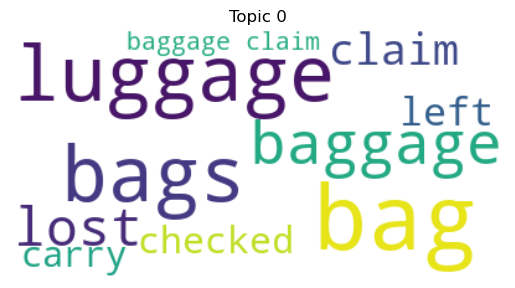

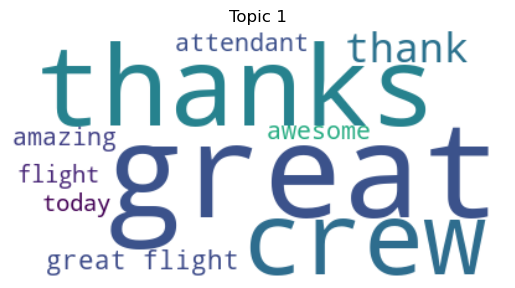

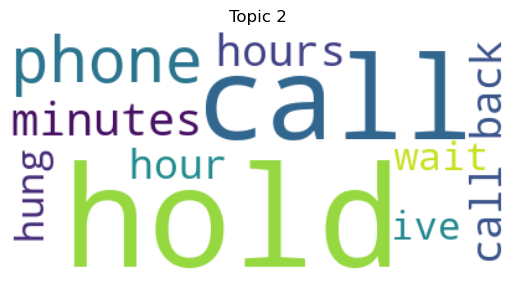

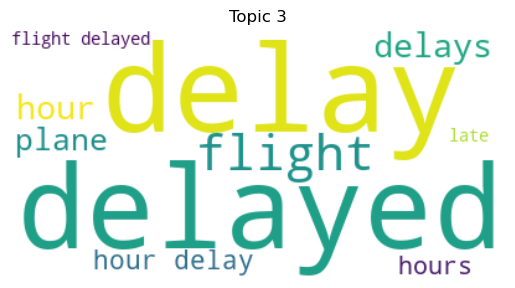

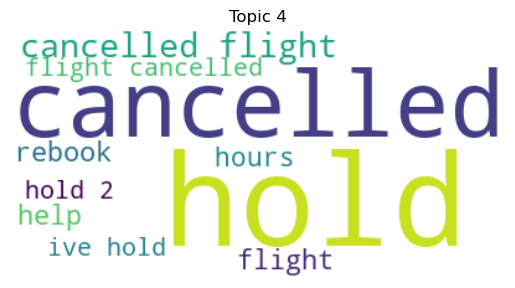

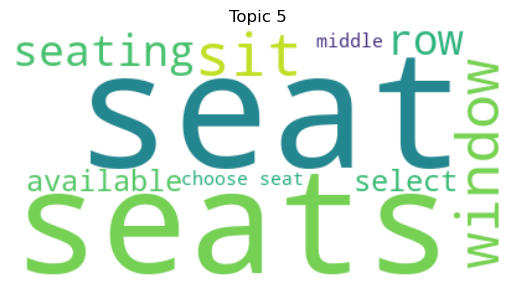

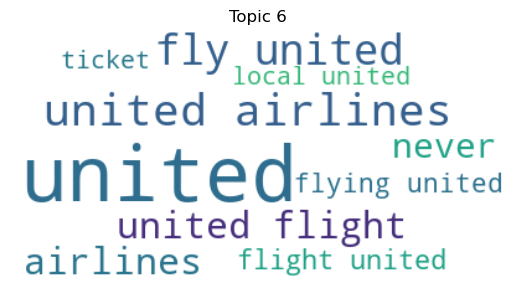

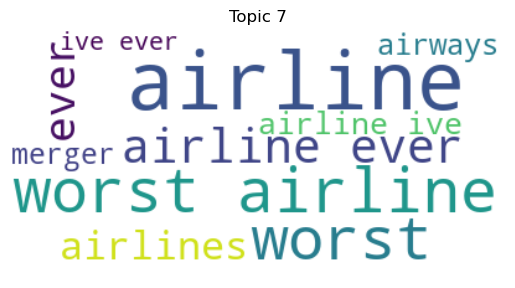

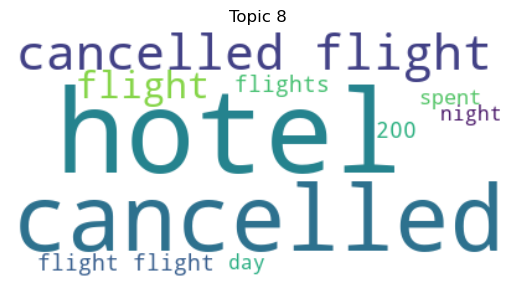

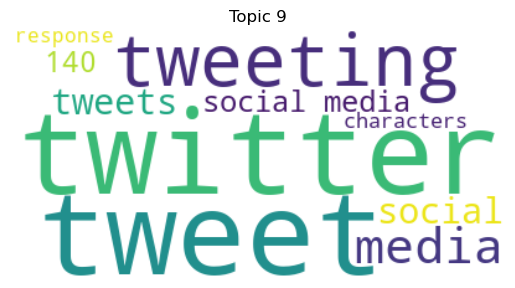

In [32]:
# Display the top 10 topics
for i in range(0, 10):
    create_wordcloud(bertmodel_mpnet, topic=i)

#### Save model:

In [33]:
# bertmodel_mpnet.save('../models/bertmodel_mpnet', save_embedding_model=True)
# bertmodel_mpnet.save('../models/bertmodel_mpnet_delay_merge', save_embedding_model=True)
# bertmodel_mpnet.save('../models/bertmodel_mpnet_delay_merge_flightspellcorrect', save_embedding_model=True)

#### To load:

In [8]:
# bertmodel_mpnet = BERTopic.load("../models/bertmodel_mpnet")
bertmodel_mpnet = BERTopic.load(
    "../models/bertmodel_mpnet_delay_merge_flightspellcorrect"
)